In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import pyrtools as pt
import plenoptic as po

%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype  = torch.float32
torch.__version__

numpy = lambda x : x.detach().cpu().numpy()

# Automatic Differentiation
aka. differentiable Programming

**references**
- https://pytorch.org/docs/stable/autograd.html
- Baydin, Pearlmutter, Radul, Siskind 2018 Automatic Differentiation in Machine Learning: a survey

In [2]:
# grad works great on vector input scalar output functions

# input
input_dim = 2

x = torch.randint(0,10,(input_dim, 1), dtype=dtype, requires_grad=True)
print(x)

# output
y = (x ** 2).sum()
print(y)

tensor([[9.],
        [9.]], requires_grad=True)
tensor(162., grad_fn=<SumBackward0>)


In [3]:
# as expected
torch.autograd.grad(y, x), 2 * x

((tensor([[18.],
          [18.]]),), tensor([[18.],
         [18.]], grad_fn=<MulBackward0>))

## Explicit Jacobian

For vector vector functions, we can explicitelly get the jacobian matrix dy/dx  
by passing impulses in the output space to backward 

In [4]:
output_dim = 3

M = torch.randint(0,10,(output_dim,input_dim), dtype=dtype)
y = torch.mm(M,x)

M

tensor([[5., 8.],
        [3., 1.],
        [3., 9.]])

In [5]:
J = torch.zeros((output_dim, input_dim))

U = torch.eye(output_dim)

torch.autograd.backward([y], [U[:,0][:,None]], retain_graph=True)
J[0,:] = x.grad.data.squeeze()
x.grad.data.zero_()
torch.autograd.backward([y], [U[:,1][:,None]], retain_graph=True)
J[1,:] = x.grad.data.squeeze()
x.grad.data.zero_()
torch.autograd.backward([y], [U[:,2][:,None]], retain_graph=True)
J[2,:] = x.grad.data.squeeze()
x.grad.data.zero_();

In [6]:
# The Jacobian is the best linear approximation to the map f
# https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant
# So in the linear case we get J = M
J

tensor([[5., 8.],
        [3., 1.],
        [3., 9.]])

In [7]:
help(po.synth.autodiff.jacobian)

Help on function jacobian in module plenoptic.synthesize.autodiff:

jacobian(y, x)
    Build the full Jacobian matrix (does not scale).
    
    Parameters
    ----------
    y: torch tensor with gradient function
        output
    x: torch tensor with gradient function
        input
    
    Returns
    -------
    J: torch tensor
        Jacobian matrix, y.size by x.size



In [8]:
po.synth.autodiff.jacobian(y, x)

tensor([[5., 8.],
        [3., 1.],
        [3., 9.]])

In [9]:
# Here is another function that does the same thing
# using the less flexible function backwards instead of grad

def _jacobian(y, x):
    n = x.shape[0]
    m = y.shape[0]
    J = torch.zeros((m, n))
    U = torch.eye(m)
    for i in range(m):
        torch.autograd.backward([y], [U[:,i][:,None]], retain_graph=True)
        J[i,:] = x.grad.data.squeeze()
        x.grad.data.zero_()
    return J

_jacobian(y, x)

tensor([[5., 8.],
        [3., 1.],
        [3., 9.]])

## Backward Mode Auto-Differentiation
### vector_jacobian_product - vector Jacobian products
u.T dy/dx

In [10]:
u = torch.randint(0,10,(output_dim, 1), dtype=dtype)

torch.autograd.backward([y], [u], retain_graph=True, create_graph=True)
print(x.grad.t())
x.grad.data.zero_();

tensor([[ 66., 116.]])


In [11]:
# check
u.t().mm(M)

tensor([[ 66., 116.]])

In [12]:
help(po.synth.autodiff.vector_jacobian_product)

Help on function vector_jacobian_product in module plenoptic.synthesize.autodiff:

vector_jacobian_product(y, x, u)
    Compute vector Jacobian product:
    vjp = u^T(∂y/∂x)
    
    aka. Backward Mode Auto-Differentiation (`Lop` in theano)
    
    Parameters
    ----------
    y: torch tensor with gradient function
        output
    x: torch tensor with gradient function
        input
    u: torch tensor
        direction, same shape as output y
    
    Returns
    -------
    uJ: torch tensor
        vector



In [13]:
po.synth.autodiff.vector_jacobian_product(y,x,u)

tensor([[ 66., 116.]])

## Forward Mode Auto-Differentiation 
### jvp - Jacobian Vector Product
(dy/dx) v  
using trick a trick described in https://j-towns.github.io/2017/06/12/A-new-trick.html

**TODO** complete the discussion on the option to retain graph in these functions in Lyndon's update

In [14]:
# now we will need gradients on u
u.requires_grad_()
g = po.synth.autodiff.vector_jacobian_product(y,x,u).t()
g

tensor([[ 66.],
        [116.]], grad_fn=<TBackward>)

In [15]:
v = torch.ones(input_dim, 1)
v[1] *= -1
torch.autograd.grad([g], [u], v, retain_graph=True, create_graph=True, allow_unused=True)[0]

tensor([[-3.],
        [ 2.],
        [-6.]])

In [16]:
# Check
M.mm(v)

tensor([[-3.],
        [ 2.],
        [-6.]])

In [17]:
help(po.synth.autodiff.jacobian_vector_product)

Help on function jacobian_vector_product in module plenoptic.synthesize.autodiff:

jacobian_vector_product(y, x, v)
    Compute Jacobian Vector Product:
    jvp = (∂y/∂x) v
    
    aka. Forward Mode Auto-Differentiation (`Rop` in theano)
    
    Parameters
    ----------
    y: torch tensor with gradient function
        output
    x: torch tensor with gradient function
        input
    v: torch tensor
        direction, same shape as input x
    
    Returns
    -------
    Jv: torch tensor
        vector
    
    Notes
    -----
    using a trick described in https://j-towns.github.io/2017/06/12/A-new-trick.html



In [18]:
po.synth.autodiff.jacobian_vector_product(y,x,v)

tensor([[-3.],
        [ 2.],
        [-6.]])

## Fisher Information Matrix Vector Product


In [19]:
help(po.synth.eigendistortion.fisher_info_matrix_vector_produt)

Help on function fisher_info_matrix_vector_produt in module plenoptic.synthesize.eigendistortion:

fisher_info_matrix_vector_produt(y, x, v)
    Compute Fisher Information Matrix Vector Product: Fv
    
    Parameters
    ----------
    y: torch tensor with gradient function
        output
    x: torch tensor with gradient function
        input
    v: torch tensor
        direction
    
    Returns
    -------
    Fv: torch tensor
        vector, fvp
    
    Notes
    -----
    under white Gaussian noise assumption, F is matrix multiplication of
    Jacobian transpose and Jacobian: F = J.T J
    Hence:
    Fv = J.T (Jv)
       = ((jvp.T) J).T



In [20]:
po.synth.eigendistortion.fisher_info_matrix_vector_produt(y,x,v)

tensor([[-27.],
        [-76.]])

In [21]:
# check
M.t().mm(M.mm(v))

tensor([[-27.],
        [-76.]])

# Power method

## get max eigenvalue/vector of the FIM

In [22]:
# TODO: rethink where this function should live
help(po.synth.eigendistortion.implicit_FIM_power_iteration)

Help on function implicit_FIM_power_iteration in module plenoptic.synthesize.eigendistortion:

implicit_FIM_power_iteration(y, x, l=0, init='randn', seed=0, tol=1e-10, n_steps=100, verbose=False)
    Apply the power method algorithm to approximate the extremal eigenvalue
    and eigenvector of the Fisher Information Matrix, without explicitely
    representing that matrix
    
    Parameters
    ----------
    y: torch tensor with gradient function
        output
    x: torch tensor
        input
    l: torch tensor, optional
        When l=0, this function estimates the leading eval evec pair.
        When l is set to the estimated maximum eigenvalue, this function
        will estimate the smallest eval evec pair (minor component).
    init: str, optional
        starting point for the power iteration
    seed: float, optional
        manual seed
    tol: float, optional
        tolerance value
    n_steps: integer, optional
        maximum number of steps
    verbose: boolean, optio

In [23]:
# testing on our running example
lmbda_max, v_max = po.synth.eigendistortion.implicit_FIM_power_iteration(y, x, verbose=True)
lmbda_min, v_min = po.synth.eigendistortion.implicit_FIM_power_iteration(y, x, lmbda_max, verbose=True)
# lightning quick convergence in this linear case

0 [3.6005707]
1 [0.00645447]
2 [1.5258789e-05]
3 [0.]
0 [170.20033]
1 [4.7683716e-07]
2 [0.]


In [24]:
# TODO make sure the new version of this function prints more user readable statements
# and maybe let it use tqdm

In [25]:
# computing the full solution for comparison
# (feasible on such a small example)
J = numpy(M)
F = np.dot(J.T, J)
evals, evecs = np.linalg.eigh(F)

In [26]:
# checking
evals[-1], lmbda_max

(181.40369, tensor([[181.4037]]))

In [27]:
evals[0], lmbda_min

(7.596318, tensor([[7.5963]]))

In [28]:
evecs[:,-1], v_max

(array([0.45132577, 0.89235926], dtype=float32), tensor([[0.4513],
         [0.8924]]))

In [29]:
evecs[:,0], v_min

(array([-0.89235926,  0.45132577], dtype=float32), tensor([[-0.8924],
         [ 0.4513]]))

## *Example 1:* synthetic data, convolve, square, normalize

In [30]:
input_dim  = 2 ** 8
output_dim = 10 * input_dim

# x = torch.randint(0,255,(input_dim, 1), dtype=dtype, requires_grad=True)
img = pt.synthetic_images.pink_noise((input_dim,1), fract_dim=1.1)
x = torch.tensor(img, dtype=dtype, requires_grad=True)

x = x / torch.norm(x)

In [31]:
# linear transformation

# RANDOM
# M = torch.randn((output_dim,input_dim))
# M = M / torch.norm(M, dim=1)[:,None]
# M.shape

# CONVOLUTION
N = output_dim - input_dim + 1
# m = torch.tensor(pt.mkFract((N,1)))
m = torch.tensor(pt.synthetic_images.sine((N,1), frequency=[.01,0]))
M = torch.zeros((output_dim,input_dim))
for i in range(input_dim):
    M[i:i+N, i] = m.squeeze()

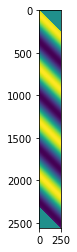

In [32]:
plt.imshow(numpy(M))

In [33]:
y = torch.pow(torch.mm(M,x), 2)
y = y / torch.norm(y)
y.shape

torch.Size([2560, 1])

In [34]:
# get the full eigendecomposition
J = po.synth.autodiff.jacobian(y, x) # full Jacobian
F = torch.mm(J.t(),J)

evals, evecs = torch.symeig(F, eigenvectors=True)


In [35]:
evals[-2] / evals[-1]


tensor(0.0269, grad_fn=<DivBackward0>)

In [36]:
lmbda_max, v_max = po.synth.eigendistortion.implicit_FIM_power_iteration(y, x, verbose=True)
lmbda_min, v_min = po.synth.eigendistortion.implicit_FIM_power_iteration(y, x, lmbda_max, verbose=True)


0 [0.0075891]
1 [4.529953e-06]
2 [1.4305115e-06]
3 [1.4305115e-06]
4 [4.7683716e-07]
5 [2.3841858e-07]
6 [0.]
0 [3.013759]
1 [0.00031614]
2 [0.00032787]
3 [0.00033991]
4 [0.00035227]
5 [0.00036492]
6 [0.0003778]
7 [0.00039104]
8 [0.00040451]
9 [0.00041824]
10 [0.00043227]
11 [0.00044646]
12 [0.00046095]
13 [0.00047559]
14 [0.00049039]
15 [0.0005054]
16 [0.00052052]
17 [0.00053573]
18 [0.00055105]
19 [0.00056645]
20 [0.00058179]
21 [0.00059721]
22 [0.00061251]
23 [0.00062784]
24 [0.0006429]
25 [0.00065788]
26 [0.00067267]
27 [0.00068716]
28 [0.00070137]
29 [0.00071533]
30 [0.00072886]
31 [0.00074198]
32 [0.00075456]
33 [0.00076676]
34 [0.00077827]
35 [0.00078931]
36 [0.00079968]
37 [0.00080935]
38 [0.00081831]
39 [0.00082655]
40 [0.00083397]
41 [0.00084059]
42 [0.00084637]
43 [0.00085132]
44 [0.00085536]
45 [0.00085846]
46 [0.00086073]
47 [0.000862]
48 [0.00086242]
49 [0.00086184]
50 [0.00086037]
51 [0.00085797]
52 [0.00085467]
53 [0.00085048]
54 [0.0008454]
55 [0.00083949]
56 [0.000832

In [37]:
evals[-1], lmbda_max 

(tensor(3.0970, grad_fn=<SelectBackward>),
 tensor([[3.0970]], grad_fn=<MmBackward>))

In [38]:
evals[0], lmbda_min

(tensor(3.1445e-09, grad_fn=<SelectBackward>),
 tensor([[0.0148]], grad_fn=<MmBackward>))

In [39]:
# TODO explain why
# power method skips small noise evals
# and stops at the elbow of the spectrum

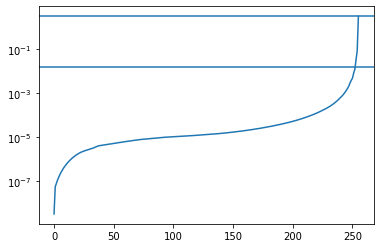

In [40]:
plt.semilogy(numpy(evals))
plt.axhline(numpy(lmbda_min))
plt.axhline(numpy(lmbda_max))

In [41]:
torch.norm(evecs[:,-1]), torch.norm(v_max)

(tensor(1.0000, grad_fn=<NormBackward0>), tensor(1., grad_fn=<NormBackward0>))

In [42]:
torch.dot(evecs[:,-1], v_max.view(-1))

tensor(1.0000, grad_fn=<DotBackward>)

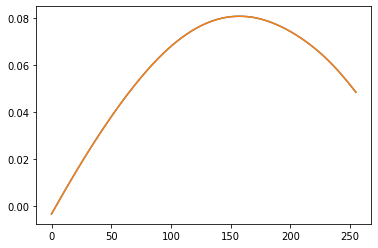

In [43]:
true = numpy(evecs[:,-1])
test = numpy(v_max).squeeze()

plt.plot(true)
plt.plot(test)

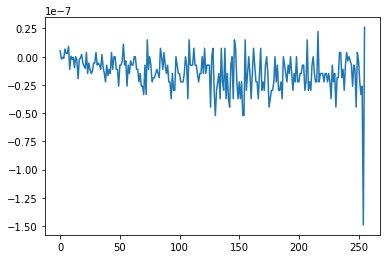

In [44]:
plt.plot(true-test);

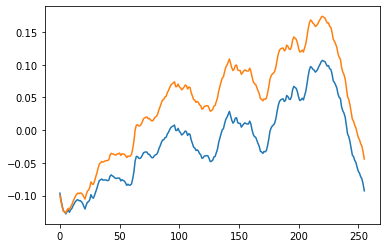

In [45]:
inpt = x.detach().numpy().squeeze()

plt.plot(inpt)
plt.plot(inpt + test)

In [46]:
# LEAST
# print(evecs[:,0].detach().dot(v_min.detach().squeeze()))
# print(torch.norm(evecs[:,0] - v_min))

# pt.imCompare(evecs[:,0].detach().numpy(), v_min.detach().numpy())

# plt.plot((evecs[:,0].detach() - v_min.detach().squeeze()).numpy())
# plt.show()

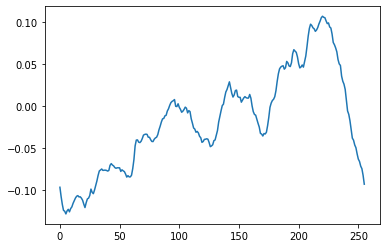

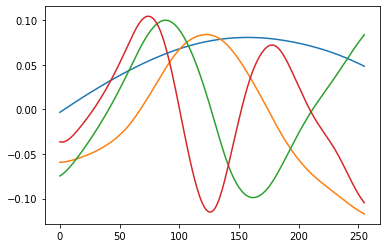

In [47]:
plt.plot(inpt)
plt.show()

# MOST
for i in range(1,5):
    plt.plot(numpy(evecs[:,-i]))
plt.show()

# LEAST
# for i in range(5):
#     plt.plot(evecs[:,i].detach().numpy())
# plt.show()

## *Example 2:* synthetic data,  Fourier transform, non-linearity

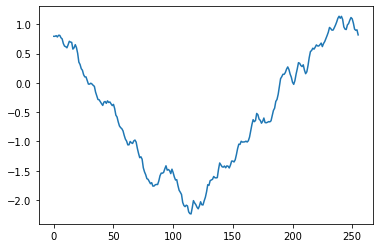

In [48]:
input_dim  = 2 ** 8
output_dim = 10 * input_dim

# x = torch.randint(0,255,(input_dim, 1), dtype=dtype, requires_grad=True)
img = pt.synthetic_images.pink_noise((input_dim, 1), fract_dim=1.2)
plt.plot(img)

x = torch.tensor(img, dtype=dtype, requires_grad=True)
x = x / torch.norm(x)

In [49]:
sp = torch.rfft(x,2)

# amplitude = torch.sqrt(torch.pow(sp.select(-1,0), 2) + torch.pow(sp.select(-1,1), 2))
# phase = torch.atan2(sp.select(-1,1),sp.select(-1,0))

amplitude, phase = po.rectangular_to_polar(sp.select(-1,0),sp.select(-1,1))

# several possibilities to explore
# y = phase
# y = amplitude
# y = torch.cat((amplitude, phase))
y = torch.cat((torch.log(torch.pow(amplitude, 2)), torch.pow(phase, 3)))

y = y / torch.norm(y)

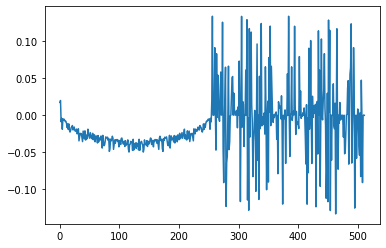

In [50]:
plt.plot(numpy(y)) #[np.roll(np.arange(input_dim), input_dim // 2)])

In [51]:
x.shape, y.shape

(torch.Size([256, 1]), torch.Size([512, 1]))

In [52]:
lmbda_max, v_max = po.synth.eigendistortion.implicit_FIM_power_iteration(y, x, verbose=True)
lmbda_min, v_min = po.synth.eigendistortion.implicit_FIM_power_iteration(y, x, lmbda_max, n_steps=1000, verbose=True)

0 [6504.8984]
1 [3641.6055]
2 [1590.9062]
3 [617.5078]
4 [234.]
5 [89.37891]
6 [34.70703]
7 [13.722656]
8 [5.421875]
9 [2.1640625]
10 [0.96484375]
11 [0.34765625]
12 [0.171875]
13 [0.0625]
14 [0.]
0 [12275.559]
1 [5338.287]
2 [7322.8057]
3 [5572.7676]
4 [2639.178]
5 [1050.3748]
6 [442.64746]
7 [223.47461]
8 [138.35742]
9 [100.00134]
10 [79.38672]
11 [66.48291]
12 [57.508667]
13 [50.849365]
14 [45.6969]
15 [41.59021]
16 [38.25]
17 [35.479248]
18 [33.15027]
19 [31.166016]
20 [29.458984]
21 [27.978638]
22 [26.684326]
23 [25.546143]
24 [24.540405]
25 [23.64795]
26 [22.852417]
27 [22.139648]
28 [21.500977]
29 [20.924316]
30 [20.402344]
31 [19.928467]
32 [19.494019]
33 [19.099976]
34 [18.734009]
35 [18.398804]
36 [18.085327]
37 [17.79309]
38 [17.519653]
39 [17.260986]
40 [17.016235]
41 [16.781128]
42 [16.559326]
43 [16.34253]
44 [16.132568]
45 [15.929932]
46 [15.731201]
47 [15.535278]
48 [15.342468]
49 [15.151733]
50 [14.960999]
51 [14.773682]
52 [14.584045]
53 [14.395935]
54 [14.206665]
55 

In [53]:
J = numpy(po.synth.autodiff.jacobian(y, x))
print(J.shape)
F = J.T.dot(J)

evals, evecs = np.linalg.eigh(F)

(512, 256)


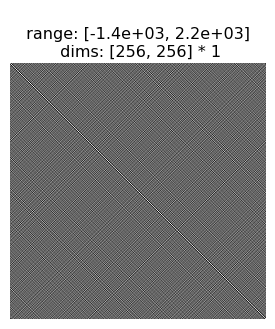

In [54]:
# little reasoning exercise
# pt.imshow(J.dot(J.T), vrange='auto3', title=None);

pt.imshow(F, vrange='auto1');

0.6677073

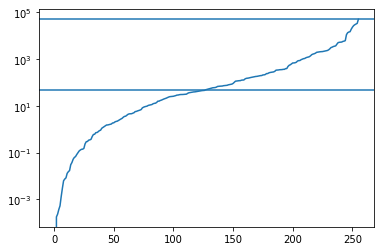

In [55]:
plt.semilogy(evals)
plt.axhline(numpy(lmbda_min))
plt.axhline(numpy(lmbda_max))
evals[-2] / evals[-1]


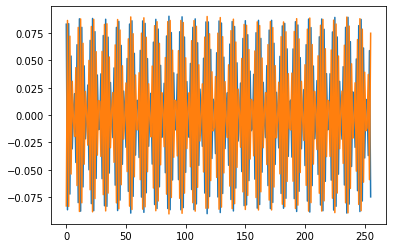

In [56]:
plt.plot(evecs[:,-1])
plt.plot(numpy(v_max).squeeze());

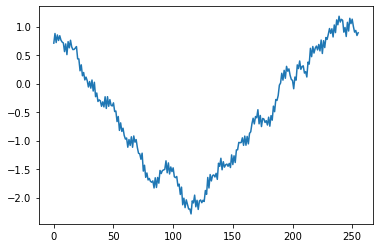

In [57]:
plt.plot(img.squeeze() + numpy(v_max).squeeze())

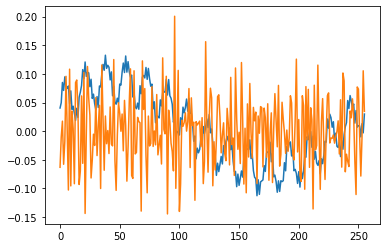

In [58]:
plt.plot(evecs[:,0])
# plt.plot(evecs[:,1])

plt.plot(numpy(v_min));

## *Example 3:* image data,  steerable pyramid, square, normalize

In [59]:
# TODO this example needs a little babysitting

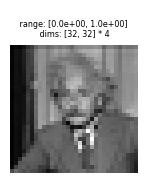

In [60]:
image = plt.imread('../data/einstein.pgm').astype(float)
image = pt.blurDn(image, 3, 'qmf9')
# keeping it small, so that we can rapidly check against the exact computation
image = po.rescale(image, 0, 1)
pt.imshow(image, zoom=4);


# TODO let the Eigendistortion class take care of that when it recieves a numpy array
x = torch.tensor(image).unsqueeze(0).unsqueeze(0)

In [86]:
class toy_model(nn.Module):
    def __init__(self):
        super(toy_model, self).__init__()

        self.SPF = po.simul.Steerable_Pyramid_Freq(image.shape, order=2, height=2)
        self.nl = po.simul.local_gain_control
    
    def forward(self, x):
        
        pyr = self.SPF(x) 
        _, state = self.nl(pyr)

        return torch.cat([s.squeeze().view(-1) for s in state.values()]).unsqueeze(1)

In [89]:
M = toy_model()

In [90]:
E = po.synth.Eigendistortion(x, M)

In [93]:
edist = E.synthesize(jac=False)

out size torch.Size([3840, 1]) in size torch.Size([1024, 1])
implicit power method, computing the maximum distortion
0 [5149.0293]
1 [3373.6328]
2 [1603.8467]
3 [809.40625]
4 [535.36914]
5 [456.73633]
6 [438.5]
7 [424.7129]
8 [393.96484]
9 [344.01367]
10 [282.77734]
11 [220.45508]
12 [164.70312]
13 [119.11719]
14 [84.11328]
15 [58.404297]
16 [40.08008]
17 [27.273438]
18 [18.449219]
19 [12.4453125]
20 [8.376953]
21 [5.6054688]
22 [3.7714844]
23 [2.5332031]
24 [1.6875]
25 [1.1367188]
26 [0.7421875]
27 [0.515625]
28 [0.34375]
29 [0.20507812]
30 [0.15429688]
31 [0.1015625]
32 [0.07421875]
33 [0.05078125]
34 [0.0234375]
35 [0.03125]
36 [0.]
implicit power method, computing the minimum distortion
0 [1989.1201]
1 [863.3003]
2 [578.7632]
3 [436.0078]
4 [344.9287]
5 [280.46924]
6 [231.78955]
7 [193.61829]
8 [163.09912]
9 [138.44629]
10 [118.42493]
11 [102.10474]
12 [88.743164]
13 [77.75952]
14 [68.690796]
15 [61.162964]
16 [54.87915]
17 [49.597412]
18 [45.125977]
19 [41.316406]
20 [38.04309]
21

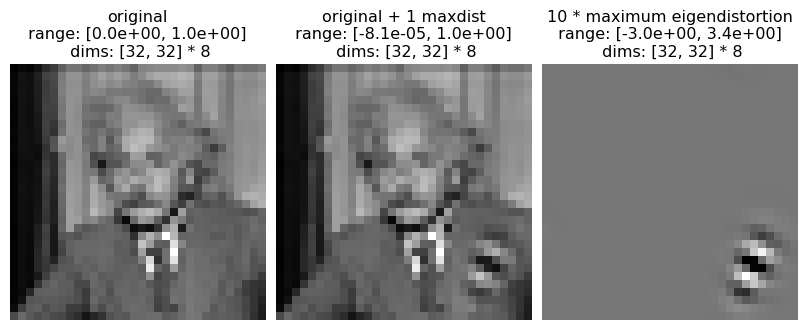

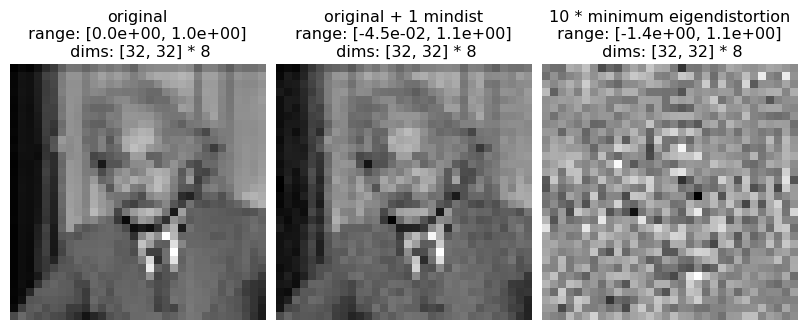

In [94]:
E.display(1, zoom = 8)

In [ ]:
# TODO
full_edist = E.synthesize(jac=True)
E.display(1, zoom = 8)

plt.semilogy([full_edist[str(i)][0] for i in range(1024)]);
plt.axhline(numpy(edist['0'][0]))
plt.axhline(numpy(edist['1023'][0]))

# Going beyond the first and last eigenvalues: Lanczos method

also compare to the block power methods

## *Example 4:* larger image